In [1]:
import statsmodels
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import os

DATA_DIR = './data/'

/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/shreyasc/anaconda3/envs/timeseries/lib/python3.6/importlib/_bootstrap.py:21

### Metrics functions

In [2]:
def mrse(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals - np.mean(actuals))))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

def re(actuals, preds):
    denom = np.sqrt(np.sum(np.square(actuals)))
    num = np.sqrt(np.sum(np.square(actuals - preds)))
    return 1.0*num/denom

## Reading Nino 3.4 data

In [3]:
filename = 'nino34_data.txt'

In [4]:
data = open(DATA_DIR + filename)
data_dict = {}

for line in data.readlines()[1:-3]:
    
    tokens = line.split(' ')
    values = []
    for token in tokens:
        if token == '':
            pass
        else:
            if '\n' in token:
                token = token[:-2]
            values.append(float(token))
    data_dict.update({values[0]:values[1:]})

In [5]:
for key,value in data_dict.items():
    print(key,value)
    assert len(value) == 12

1948.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1949.0 [-99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.99, -99.9]
1950.0 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951.0 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952.0 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953.0 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954.0 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955.0 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956.0 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957.0 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958.0 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45

## Filtering data to have 1950 - 2008

In [6]:
filtered_data = {int(year): data_dict[year] for year in data_dict.keys() if year >= 1950 and year <=2008 }

In [7]:
for key,value in filtered_data.items():
    print(key,value)
    assert len(value) == 12

1950 [24.55, 25.06, 25.87, 26.28, 26.18, 26.46, 26.29, 25.88, 25.74, 25.69, 25.47, 25.2]
1951 [25.24, 25.71, 26.9, 27.58, 27.92, 27.73, 27.6, 27.02, 27.23, 27.2, 27.25, 26.9]
1952 [26.67, 26.74, 27.17, 27.8, 27.79, 27.18, 26.53, 26.3, 26.36, 26.26, 25.92, 26.2]
1953 [26.74, 27.0, 27.57, 28.04, 28.28, 28.12, 27.43, 26.94, 27.01, 26.87, 26.88, 27.0]
1954 [26.98, 27.03, 26.9, 26.64, 27.12, 26.8, 26.11, 25.43, 25.12, 25.23, 25.57, 25.2]
1955 [25.61, 25.81, 26.22, 26.6, 26.66, 26.55, 26.15, 25.51, 25.28, 24.41, 24.25, 24.5]
1956 [25.34, 25.76, 26.46, 26.85, 27.13, 26.81, 26.23, 25.68, 25.73, 25.75, 25.56, 25.7]
1957 [26.04, 26.54, 27.46, 28.23, 28.55, 28.36, 28.17, 27.69, 27.44, 27.42, 27.62, 27.9]
1958 [28.33, 28.24, 28.27, 28.27, 28.31, 27.99, 27.32, 26.85, 26.4, 26.45, 26.75, 26.6]
1959 [27.07, 27.18, 27.47, 27.88, 27.7, 27.37, 26.44, 26.09, 25.92, 26.24, 26.04, 26.1]
1960 [26.27, 26.29, 26.98, 27.49, 27.68, 27.24, 26.88, 26.7, 26.44, 26.22, 26.26, 26.2]
1961 [26.23, 26.56, 26.94, 27.36,

## Reading Nino 3.4 Anomaly data

In [54]:
filename = 'nino34_anomalies.txt'

In [62]:
anomaly_data = open(DATA_DIR + filename)
anomaly_data_dict = {}

for line in anomaly_data.readlines():  
    _,year,value = line.split(' ')
    value = float(value[:-2])
    year = int(float(year))
    if year in anomaly_data_dict:
        anomaly_data_dict[year]=anomaly_data_dict[year]+[value]
    else:
        anomaly_data_dict.update({year:[value]})

In [63]:
for key,value in anomaly_data_dict.items():
    print(key,value)
    assert len(value) == 12

1950 [-2.0023333333333, -1.6816666666666, -1.3646666666666, -1.4296666666666, -1.632, -1.13, -0.88866666666666, -0.954, -0.98733333333332, -0.983, -1.1576666666666, -1.27]
1951 [-1.3123333333333, -1.0316666666666, -0.33466666666666, -0.12966666666667, 0.10799999999999, 0.13899999999999, 0.42133333333333, 0.18, 0.50266666666667, 0.52699999999999, 0.62233333333333, 0.34]
1952 [0.11766666666667, -0.0016666666666722, -0.06466666666666, 0.090333333333322, -0.022000000000009, -0.411, -0.64866666666666, -0.53399999999999, -0.36733333333332, -0.41, -0.70766666666666, -0.35099999999999]
1953 [0.18766666666667, 0.25833333333332, 0.33533333333333, 0.33033333333332, 0.46799999999999, 0.52, 0.25133333333333, 0.106, 0.28266666666667, 0.19699999999999, 0.25233333333333, 0.43]
1954 [0.42766666666667, 0.2883333333333, -0.33466666666666, -1.0696666666666, -0.692, -0.79, -1.0686666666666, -1.4, -1.6073333333333, -1.44, -1.0576666666666, -1.3]
1955 [-0.94233333333332, -0.93166666666667, -1.0146666666666, 

## Flattening time series data

In [64]:
filtered_ts = np.array([])
filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()

In [65]:
assert len(filtered_ts) == (2008-1950+1)*12

In [66]:
filtered_anomalies = np.array([])
filtered_anomalies = np.array([np.concatenate((filtered_anomalies,val)) for val in anomaly_data_dict.values()]).flatten()

In [67]:
assert len(filtered_anomalies) == (2008-1950+1)*12

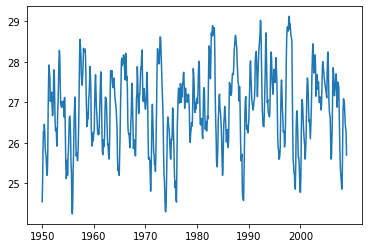

In [68]:
plt.plot(filtered_ts)
plt.xticks(range(0,708+1,12*10),labels=range(1950,2008+1,10))
plt.show()

In [121]:
def get_data(data,years,subtract_mean=False,means=None):
    if subtract_mean == True:
        assert means is not None
    filtered_data = {int(year): data[year] for year in data.keys() if year in years }
    filtered_ts = np.array([])
    if subtract_mean:
        filtered_ts = np.array([np.concatenate((filtered_ts,val-means)) for val in filtered_data.values()]).flatten()
    else:
        filtered_ts = np.array([np.concatenate((filtered_ts,val)) for val in filtered_data.values()]).flatten()
    return filtered_ts

### Train Test Split

In [122]:
train_test_ratio = 0.8
years = np.array(list(filtered_data.keys()))
print('Total years available')
print(years)
print(f'Train Test ratio: {train_test_ratio}')
training_years = years[:int(train_test_ratio*len(years))]
print(f'No of years in training: {len(training_years)}')
print(training_years)
testing_years = years[int(train_test_ratio*len(years)):]
print(f'No of years in testing: {len(testing_years)}')
print(testing_years)

Total years available
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008]
Train Test ratio: 0.8
No of years in training: 47
[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996]
No of years in testing: 12
[1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]


## Calculating monthly means across all training years

In [140]:
means = np.zeros(12)
for key,value in filtered_data.items():
    if int(key) in training_years:
        means += np.array(value)
means /= len(training_years)
print(means)

[26.43340426 26.63085106 27.10021277 27.51       27.61638298 27.42085106
 26.98765957 26.58851064 26.47744681 26.43723404 26.42957447 26.37021277]


In [124]:
for key,value in filtered_data.items():
    print(key,value-means)
    assert len(value) == 12

1950 [-1.88340426 -1.57085106 -1.23021277 -1.23       -1.43638298 -0.96085106
 -0.69765957 -0.70851064 -0.73744681 -0.74723404 -0.95957447 -1.17021277]
1951 [-1.19340426 -0.92085106 -0.20021277  0.07        0.30361702  0.30914894
  0.61234043  0.43148936  0.75255319  0.76276596  0.82042553  0.52978723]
1952 [ 0.23659574  0.10914894  0.06978723  0.29        0.17361702 -0.24085106
 -0.45765957 -0.28851064 -0.11744681 -0.17723404 -0.50957447 -0.17021277]
1953 [0.30659574 0.36914894 0.46978723 0.53       0.66361702 0.69914894
 0.44234043 0.35148936 0.53255319 0.43276596 0.45042553 0.62978723]
1954 [ 0.54659574  0.39914894 -0.20021277 -0.87       -0.49638298 -0.62085106
 -0.87765957 -1.15851064 -1.35744681 -1.20723404 -0.85957447 -1.17021277]
1955 [-0.82340426 -0.82085106 -0.88021277 -0.91       -0.95638298 -0.87085106
 -0.83765957 -1.07851064 -1.19744681 -2.02723404 -2.17957447 -1.87021277]
1956 [-1.09340426 -0.87085106 -0.64021277 -0.66       -0.48638298 -0.61085106
 -0.75765957 -0.908510

In [125]:
training_data = get_data(filtered_data,training_years,subtract_mean=True,means=means)
training_anomalies = get_data(anomaly_data_dict,training_years)

In [126]:
len(training_data),len(training_anomalies)

(564, 564)

In [127]:
assert len(training_years)*12 == len(training_data)
assert len(training_years)*12 == len(training_anomalies)

### Plotting training data, mean, acf and pacf

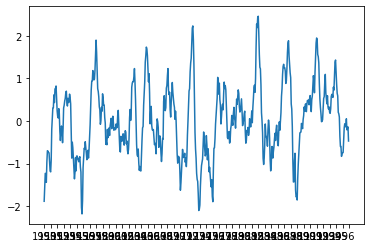

In [129]:
plt.plot(training_data)
plt.xticks(range(0,len(training_data)+1,12),labels=training_years)
plt.show()

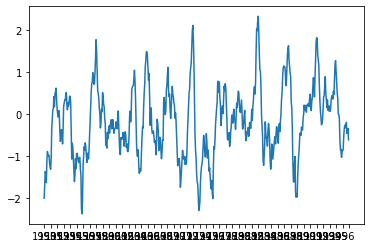

In [130]:
plt.plot(training_anomalies)
plt.xticks(range(0,len(training_anomalies)+1,12),labels=training_years)
plt.show()

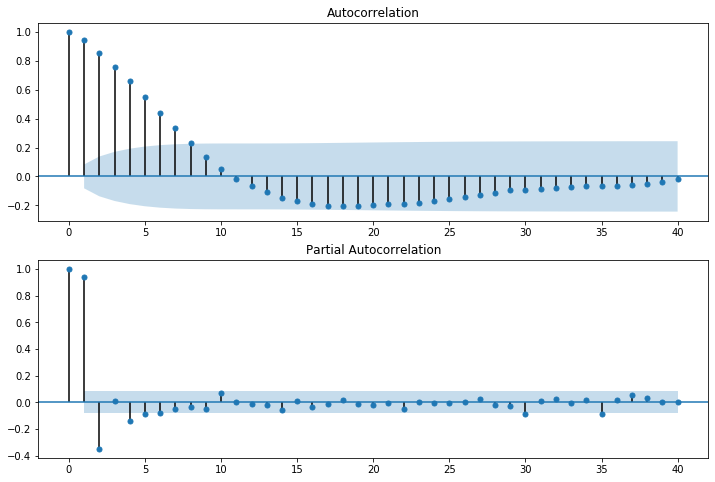

In [133]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data, lags=40, ax=ax2)
plt.show()

### Fitting AR model

In [171]:
p=6

In [172]:
formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))

In [173]:
arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
print(arma_mod.params)

const     -0.022353
ar.L1.y    1.324662
ar.L2.y   -0.488000
ar.L3.y    0.207255
ar.L4.y   -0.098730
ar.L5.y    0.070119
ar.L6.y   -0.106702
dtype: float64


### Getting predictions for test set

In [174]:
predictions = arma_mod.predict(start=f'{testing_years[0]}m1', end=f'{testing_years[-1]}m12', dynamic=False)
test_data = get_data(filtered_data,testing_years)
test_anomalies = get_data(anomaly_data_dict,testing_years)

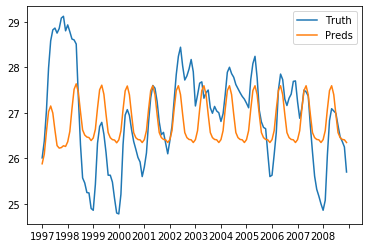

In [175]:
plt.plot(test_data,label='Truth')
plt.plot(predictions.values+np.tile(means, len(testing_years)),label='Preds')
plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
plt.legend()
plt.show()

In [178]:
test_mrse = mrse(test_data,predictions.values+np.tile(means, len(testing_years)))
test_re = re(test_data,predictions.values+np.tile(means, len(testing_years)))
print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

Test MRSE: 0.9488719788537961
Test RE: 0.03663244001361914


### Grid search over different lags to find best model

For P: 1
const     -0.077018
ar.L1.y    0.951804
dtype: float64


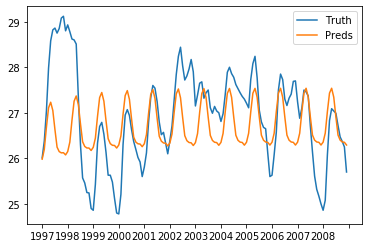

Test MRSE: 0.9547079496620304
Test RE: 0.03685774527641352
For P: 2
const     -0.038012
ar.L1.y    1.326019
ar.L2.y   -0.394844
dtype: float64


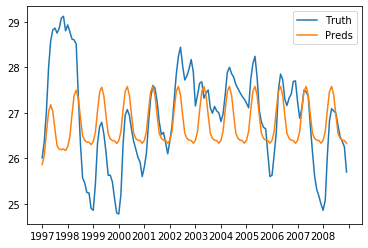

Test MRSE: 0.9527687322641115
Test RE: 0.036782879260148144
For P: 3
const     -0.040036
ar.L1.y    1.338441
ar.L2.y   -0.436637
ar.L3.y    0.031612
dtype: float64


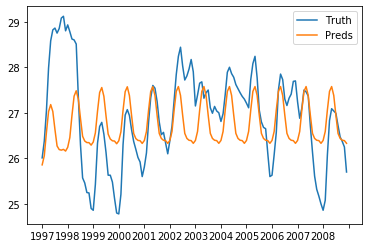

Test MRSE: 0.9535107489708543
Test RE: 0.03681152578265552
For P: 4
const     -0.030872
ar.L1.y    1.342664
ar.L2.y   -0.499060
ar.L3.y    0.223606
ar.L4.y   -0.143814
dtype: float64


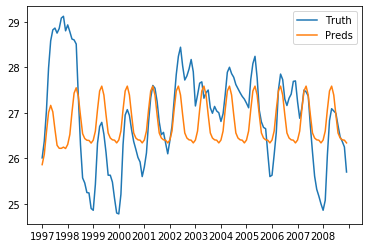

Test MRSE: 0.9503589999849574
Test RE: 0.03668984840337058
For P: 5
const     -0.026984
ar.L1.y    1.332269
ar.L2.y   -0.483332
ar.L3.y    0.188113
ar.L4.y   -0.047334
ar.L5.y   -0.072128
dtype: float64


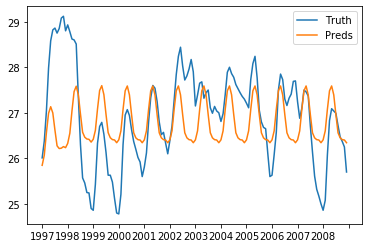

Test MRSE: 0.9509961352328969
Test RE: 0.03671444584040197
For P: 6
const     -0.022353
ar.L1.y    1.324662
ar.L2.y   -0.488000
ar.L3.y    0.207255
ar.L4.y   -0.098730
ar.L5.y    0.070119
ar.L6.y   -0.106702
dtype: float64


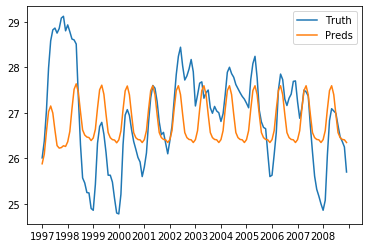

Test MRSE: 0.9488719788537961
Test RE: 0.03663244001361914
For P: 7
const     -0.021103
ar.L1.y    1.321178
ar.L2.y   -0.485726
ar.L3.y    0.204150
ar.L4.y   -0.092125
ar.L5.y    0.054040
ar.L6.y   -0.063165
ar.L7.y   -0.032806
dtype: float64


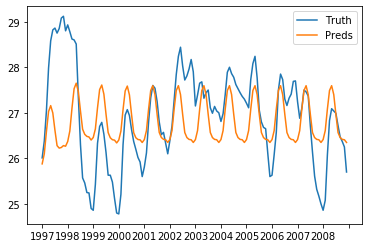

Test MRSE: 0.9486516010402546
Test RE: 0.03662393204076843
For P: 8
const     -0.019851
ar.L1.y    1.320076
ar.L2.y   -0.487731
ar.L3.y    0.205884
ar.L4.y   -0.094869
ar.L5.y    0.060237
ar.L6.y   -0.078707
ar.L7.y    0.009576
ar.L8.y   -0.032032
dtype: float64


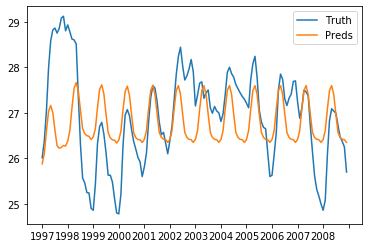

Test MRSE: 0.9485894661315338
Test RE: 0.03662153324159721
For P: 9
const     -0.017897
ar.L1.y    1.318421
ar.L2.y   -0.487277
ar.L3.y    0.202197
ar.L4.y   -0.091964
ar.L5.y    0.055935
ar.L6.y   -0.069366
ar.L7.y   -0.013642
ar.L8.y    0.031054
ar.L9.y   -0.047748
dtype: float64


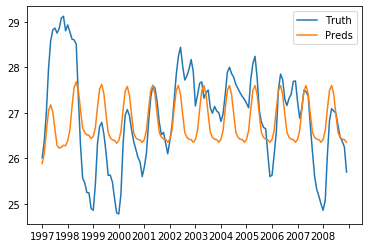

Test MRSE: 0.9478285875305948
Test RE: 0.036592158531069646
For P: 10
const      -0.022865
ar.L1.y     1.323466
ar.L2.y    -0.490379
ar.L3.y     0.203448
ar.L4.y    -0.085200
ar.L5.y     0.050271
ar.L6.y    -0.060760
ar.L7.y    -0.032304
ar.L8.y     0.078061
ar.L9.y    -0.175664
ar.L10.y    0.097058
dtype: float64


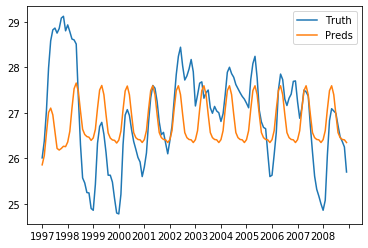

Test MRSE: 0.9528707787653491
Test RE: 0.0367868188983907
For P: 11
const      -0.023933
ar.L1.y     1.322032
ar.L2.y    -0.487609
ar.L3.y     0.202181
ar.L4.y    -0.084707
ar.L5.y     0.051288
ar.L6.y    -0.061615
ar.L7.y    -0.031046
ar.L8.y     0.075039
ar.L9.y    -0.168078
ar.L10.y    0.076438
ar.L11.y    0.015630
dtype: float64


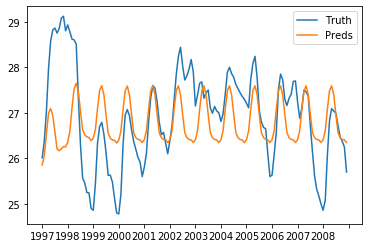

Test MRSE: 0.9541812790901845
Test RE: 0.03683741247224178
For P: 12
const      -0.023332
ar.L1.y     1.322150
ar.L2.y    -0.487028
ar.L3.y     0.200786
ar.L4.y    -0.084032
ar.L5.y     0.050979
ar.L6.y    -0.062129
ar.L7.y    -0.030582
ar.L8.y     0.074377
ar.L9.y    -0.166498
ar.L10.y    0.072461
ar.L11.y    0.026524
ar.L12.y   -0.008280
dtype: float64


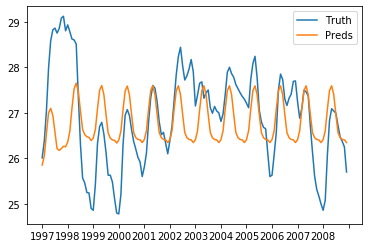

Test MRSE: 0.9534772917250335
Test RE: 0.03681023412205445
For P: 13
const      -0.021739
ar.L1.y     1.321934
ar.L2.y    -0.486457
ar.L3.y     0.202226
ar.L4.y    -0.087659
ar.L5.y     0.052742
ar.L6.y    -0.062942
ar.L7.y    -0.031927
ar.L8.y     0.075588
ar.L9.y    -0.168203
ar.L10.y    0.076566
ar.L11.y    0.016134
ar.L12.y    0.020140
ar.L13.y   -0.021604
dtype: float64


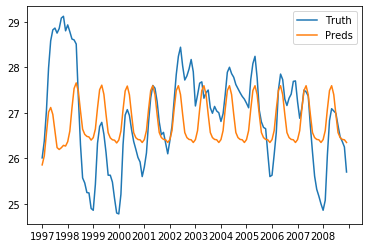

Test MRSE: 0.9511474514546333
Test RE: 0.03672028760044903
For P: 14
const      -0.017301
ar.L1.y     1.320505
ar.L2.y    -0.485165
ar.L3.y     0.203273
ar.L4.y    -0.083008
ar.L5.y     0.041551
ar.L6.y    -0.057494
ar.L7.y    -0.034571
ar.L8.y     0.071349
ar.L9.y    -0.164281
ar.L10.y    0.070954
ar.L11.y    0.029041
ar.L12.y   -0.012202
ar.L13.y    0.067110
ar.L14.y   -0.067444
dtype: float64


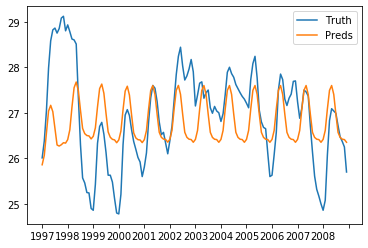

Test MRSE: 0.9430761808245332
Test RE: 0.036408685673339755
For P: 15
const      -0.016448
ar.L1.y     1.319364
ar.L2.y    -0.483925
ar.L3.y     0.202967
ar.L4.y    -0.082536
ar.L5.y     0.042916
ar.L6.y    -0.060594
ar.L7.y    -0.033183
ar.L8.y     0.070568
ar.L9.y    -0.165330
ar.L10.y    0.071742
ar.L11.y    0.027658
ar.L12.y   -0.008622
ar.L13.y    0.058316
ar.L14.y   -0.043111
ar.L15.y   -0.018542
dtype: float64


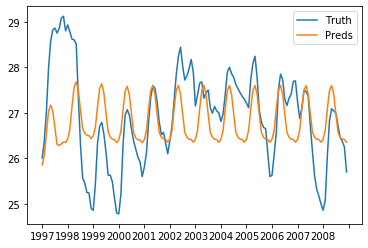

Test MRSE: 0.9413444190306893
Test RE: 0.03634182875117888
For P: 16
const      -0.014809
ar.L1.y     1.318650
ar.L2.y    -0.485196
ar.L3.y     0.205051
ar.L4.y    -0.083071
ar.L5.y     0.043878
ar.L6.y    -0.057983
ar.L7.y    -0.039215
ar.L8.y     0.073241
ar.L9.y    -0.166771
ar.L10.y    0.069606
ar.L11.y    0.029183
ar.L12.y   -0.011252
ar.L13.y    0.065237
ar.L14.y   -0.060115
ar.L15.y    0.028503
ar.L16.y   -0.035867
dtype: float64


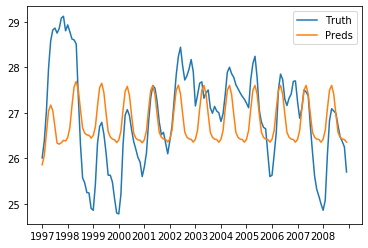

Test MRSE: 0.9374731484363716
Test RE: 0.03619237330198948
For P: 17
const      -0.013825
ar.L1.y     1.317762
ar.L2.y    -0.484503
ar.L3.y     0.203589
ar.L4.y    -0.081255
ar.L5.y     0.043385
ar.L6.y    -0.057215
ar.L7.y    -0.037314
ar.L8.y     0.068646
ar.L9.y    -0.164705
ar.L10.y    0.068328
ar.L11.y    0.027711
ar.L12.y   -0.010079
ar.L13.y    0.063231
ar.L14.y   -0.054701
ar.L15.y    0.015521
ar.L16.y   -0.000441
ar.L17.y   -0.027002
dtype: float64


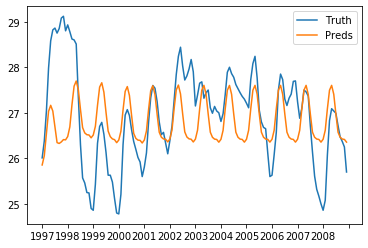

Test MRSE: 0.9356101517556991
Test RE: 0.03612044988590047
For P: 18
const      -0.014814
ar.L1.y     1.318506
ar.L2.y    -0.484502
ar.L3.y     0.203232
ar.L4.y    -0.080042
ar.L5.y     0.041799
ar.L6.y    -0.056884
ar.L7.y    -0.038097
ar.L8.y     0.066668
ar.L9.y    -0.159813
ar.L10.y    0.066235
ar.L11.y    0.028948
ar.L12.y   -0.008464
ar.L13.y    0.061993
ar.L14.y   -0.052617
ar.L15.y    0.009817
ar.L16.y    0.013320
ar.L17.y   -0.064778
ar.L18.y    0.028843
dtype: float64


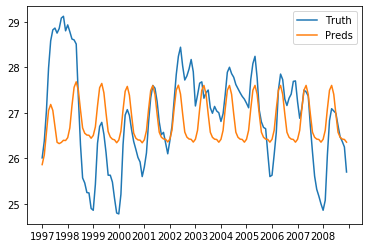

Test MRSE: 0.9359893128822117
Test RE: 0.03613508789559198
For P: 19
const      -0.014087
ar.L1.y     1.319189
ar.L2.y    -0.485937
ar.L3.y     0.203533
ar.L4.y    -0.079982
ar.L5.y     0.041067
ar.L6.y    -0.055755
ar.L7.y    -0.038330
ar.L8.y     0.067308
ar.L9.y    -0.158259
ar.L10.y    0.062425
ar.L11.y    0.030555
ar.L12.y   -0.009418
ar.L13.y    0.060707
ar.L14.y   -0.051588
ar.L15.y    0.008115
ar.L16.y    0.017866
ar.L17.y   -0.075774
ar.L18.y    0.058898
ar.L19.y   -0.022901
dtype: float64


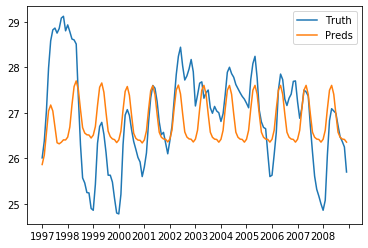

Test MRSE: 0.9360394396367615
Test RE: 0.03613702310431354


In [179]:
max_p = 20
p_list = np.array(range(1,max_p))
mrse_list = []
re_list = []
for p in p_list:
    print(f'For P: {p}')
    formatted_training_data = pd.Series(data=training_data,index=pd.Index(sm.tsa.datetools.dates_from_range(f'{training_years[0]}m1', length=len(training_data))))
    arma_mod = sm.tsa.ARMA(formatted_training_data, (p,0)).fit(disp=False)
    print(arma_mod.params)
    predictions = arma_mod.predict(start=f'{testing_years[0]}m1', end=f'{testing_years[-1]}m12', dynamic=False)
    test_data = get_data(filtered_data,testing_years)
    test_anomalies = get_data(anomaly_data_dict,testing_years)
    plt.plot(test_data,label='Truth')
    plt.plot(predictions.values+np.tile(means, len(testing_years)),label='Preds')
    plt.xticks(range(0,len(test_data)+1,12),labels=testing_years)
    plt.legend()
    plt.show()
    test_mrse = mrse(test_data,predictions.values+np.tile(means, len(testing_years)))
    test_re = re(test_data,predictions.values+np.tile(means, len(testing_years)))
    mrse_list.append(test_mrse)
    re_list.append(test_re)
    print(f'Test MRSE: {test_mrse}\nTest RE: {test_re}')

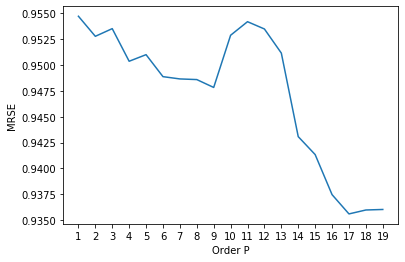

In [180]:
plt.plot(mrse_list)
plt.xticks(p_list-1,labels=p_list)
plt.ylabel('MRSE')
plt.xlabel('Order P')
plt.show()

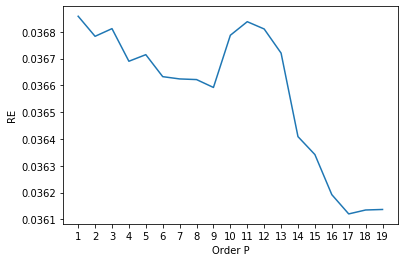

In [181]:
plt.plot(re_list)
plt.xticks(p_list-1,labels=p_list)
plt.ylabel('RE')
plt.xlabel('Order P')
plt.show()